In [ ]:
%config InlineBackend.figure_format='retina'

from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import __module_import__
from catbond import *
from dynamic_contagion import *
from market_conditions import *
from reinsurance import *

In [ ]:
# Other parameters
maturity = 3
markup = 0.4
R = int(1e4)
seed = 123

# Asset parameters
V_0 = 130
phi_V = -3  # * (1.3) # = V0 / L0
sigma_V = 0.05

# Liability parameters
L_0 = 100
phi_L = -3
sigma_L = 0.02

# Interest rate parameters
r_0 = 0.02
k = 0.2
m = 0.05  # 0.5
upsilon = 0.1
eta_r = -0.01

# Catastrophe loss size distribution parameters
mu_C = 2
sigma_C = 0.5

# Catbond (constant) parameters
catbond_markup = 0.05

In [ ]:
# Poisson process
def simulate_poisson(seed):
    lambda_ = 0.5
    rg = rnd.default_rng(seed)
    return rg.poisson(lambda_ * maturity)


# Cox proces
def simulate_cox(seed):
    lambda0 = 0.49
    a = 0.4
    rho = 0.4
    delta = 1

    return simulate_num_dynamic_contagion_uniform_jumps(
        seed, maturity, lambda0, a, rho, delta, 0.0, 0.0, 0.0, 0.5
    )


# Hawkes process
def simulate_hawkes(seed):
    lambda0 = 0.47
    a = 0.26
    rho = 0.4
    delta = 1

    return simulate_num_dynamic_contagion_uniform_jumps(
        seed, maturity, lambda0, a, rho, delta, 0.0, 1.0, 0.0, 0.0
    )


# Dynamic contagion process
def simulate_dcp(seed):
    lambda0 = 0.29
    a = 0.26
    rho = 0.4
    delta = 1

    return simulate_num_dynamic_contagion_uniform_jumps(
        seed, maturity, lambda0, a, rho, delta, 0.0, 1.0, 0.0, 0.5
    )

In [ ]:
reinsurance_prices_with_catbonds = reinsurance_prices(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    (simulate_poisson, simulate_cox, simulate_hawkes, simulate_dcp),
    mu_C,
    sigma_C,
    markup,
    catbond=True,
    K=(20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0),
    F=(0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0),
)

Poisson


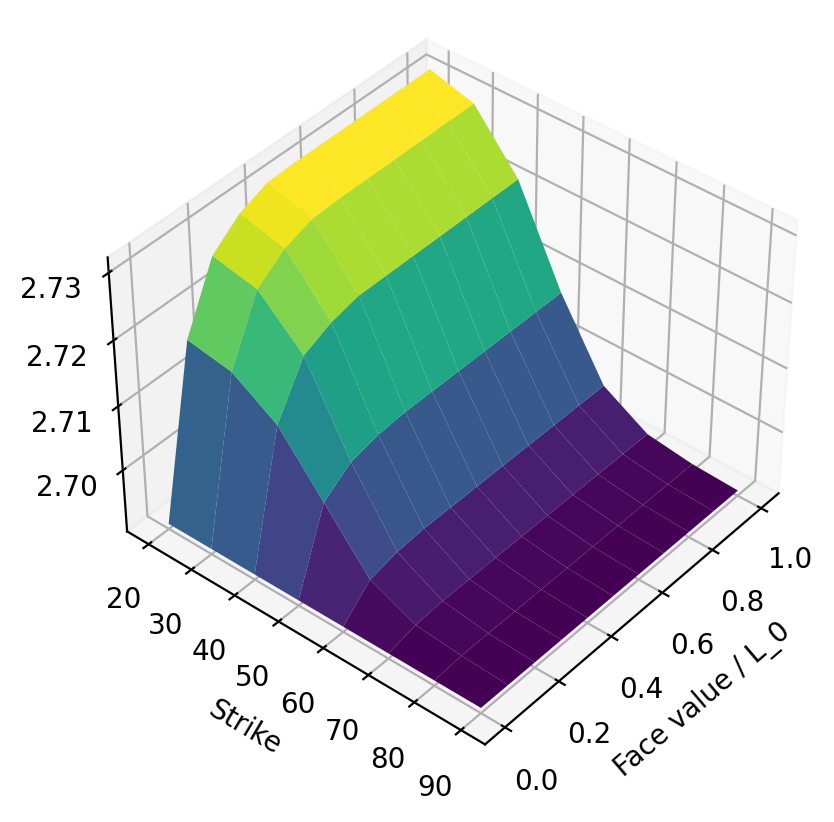

Cox


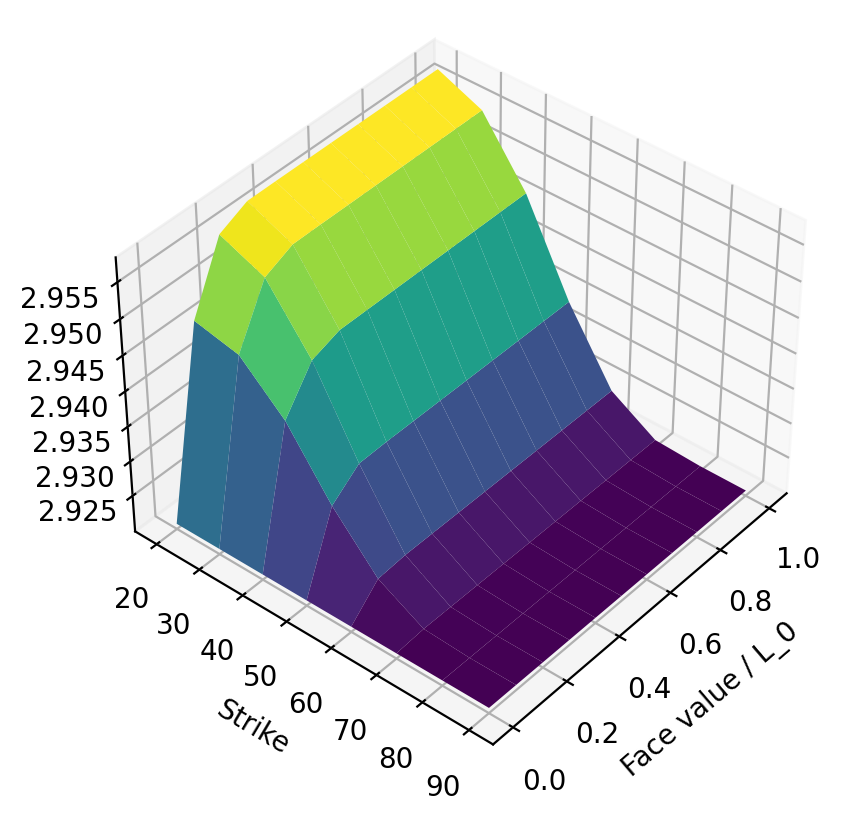

Hawkes


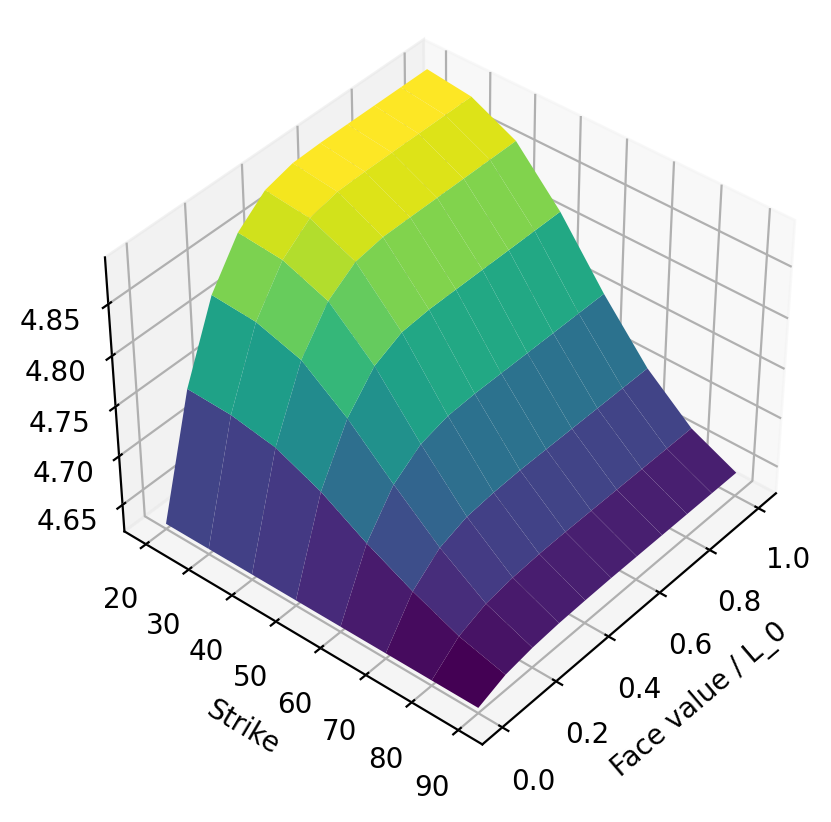

DCP


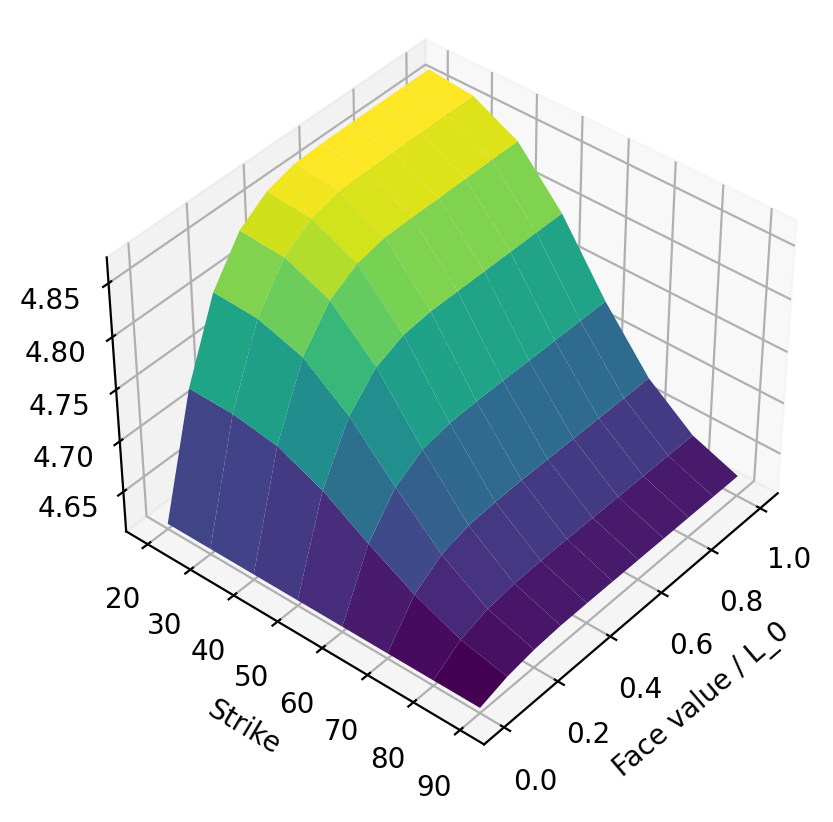

In [ ]:
names = ("Poisson", "Cox", "Hawkes", "DCP")

Fs = np.array([0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0])
X = np.array([F / L_0 for F in Fs])
Y = np.array([20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0])
X, Y = np.meshgrid(X, Y)

for i, name in enumerate(names):
    print(name)

    Z = reinsurance_prices_with_catbonds[i]

    # Plot a colourful 3D surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")

    # Plot with the smallest values closest to us
    ax.invert_xaxis()

    # Rotate the plot 40 degrees
    ax.view_init(40, 40)

    plt.xlabel("Face value / L_0")
    plt.ylabel("Strike")

    plt.show()

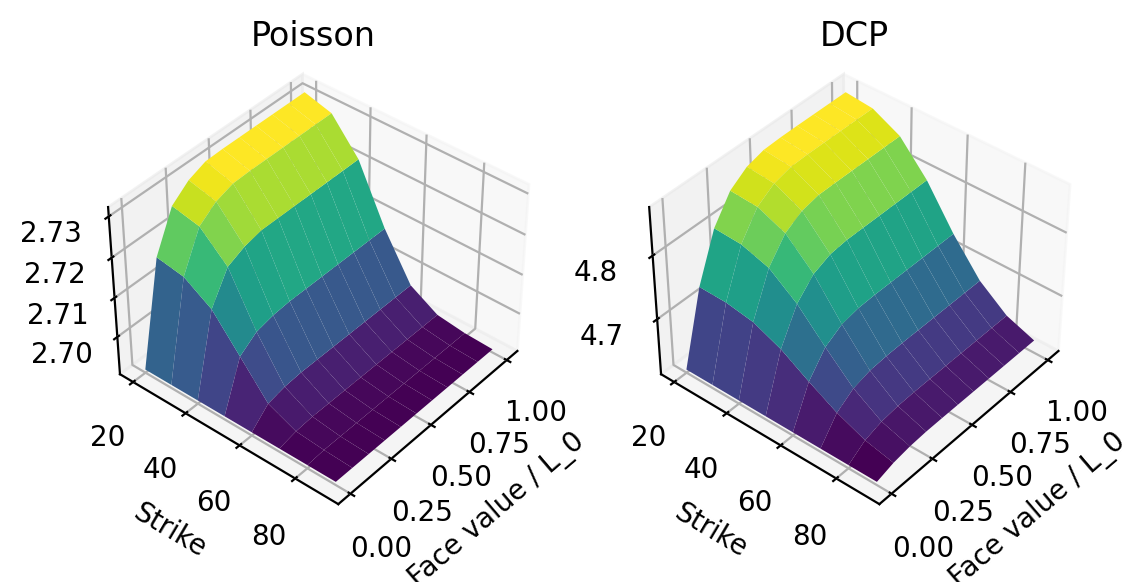

In [ ]:
# Create two 3D subplots
fig = plt.figure()
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

# Plot the first subplot
for i in (0, 3):
    ax = ax1 if i == 0 else ax2
    Z = reinsurance_prices_with_catbonds[i]

    # Plot a colourful 3D surface
    ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")

    # Plot with the smallest values closest to us
    ax.invert_xaxis()

    # Rotate the plot 40 degrees
    ax.view_init(40, 40)

    ax.set_xlabel("Face value / L_0")
    ax.set_ylabel("Strike")

    ax.set_title("Poisson" if i == 0 else "DCP")

plt.savefig("poisson-dcp.png", dpi=300, bbox_inches="tight")

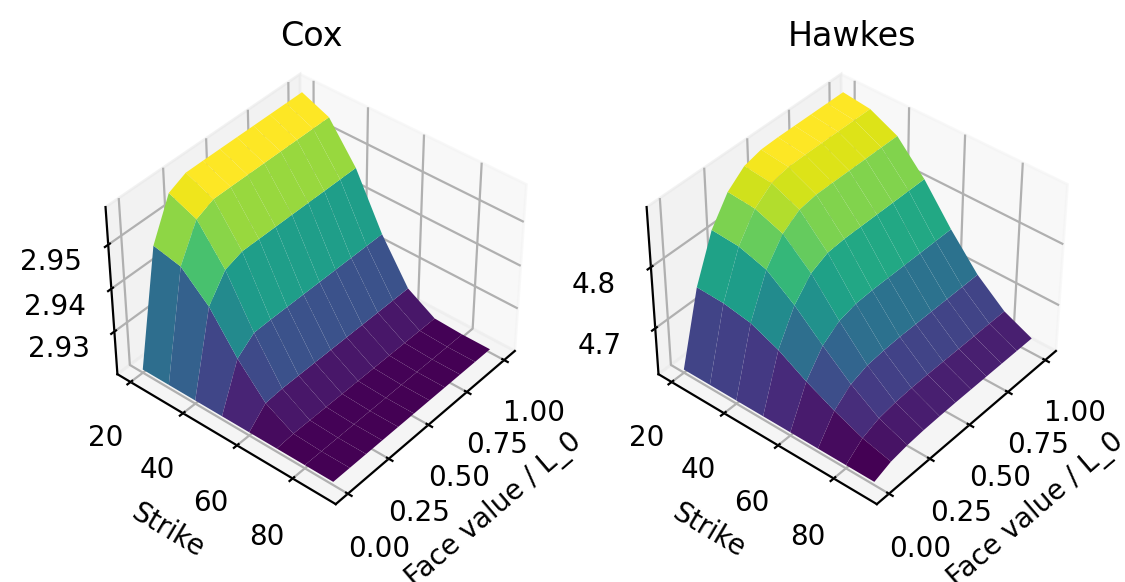

In [ ]:
# Create two 3D subplots
fig = plt.figure()
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

# Plot the first subplot
for i in (1, 2):
    ax = ax1 if i == 1 else ax2
    Z = reinsurance_prices_with_catbonds[i]

    # Plot a colourful 3D surface
    ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")

    # Plot with the smallest values closest to us
    ax.invert_xaxis()

    # Rotate the plot 40 degrees
    ax.view_init(40, 40)

    ax.set_xlabel("Face value / L_0")
    ax.set_ylabel("Strike")

    ax.set_title("Cox" if i == 1 else "Hawkes")

plt.savefig("cox-hawkes.png", dpi=300, bbox_inches="tight")

In [ ]:
%%time

safe_prices = reinsurance_prices(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    (simulate_poisson, simulate_cox, simulate_hawkes, simulate_dcp),
    mu_C,
    sigma_C,
    markup,
    catbond=True,
    K=40.0,
    F=10.0,
)

risky_prices = reinsurance_prices(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    (simulate_poisson, simulate_cox, simulate_hawkes, simulate_dcp),
    mu_C,
    sigma_C,
    markup,
)

catbond_premium = safe_prices - risky_prices

CPU times: total: 719 ms
Wall time: 734 ms


In [ ]:
safe_prices

array([2.71122407, 2.93962846, 4.73575257, 4.72146589])

In [ ]:
risky_prices

array([2.69105338, 2.92050976, 4.62767411, 4.61521789])

In [ ]:
catbond_premium / risky_prices * 100

array([0.74954639, 0.65463567, 2.33548131, 2.3021231 ])

In [ ]:
risky_prices, safe_prices, catbond_premium

(array([2.69105338, 2.92050976, 4.62767411, 4.61521789]),
 array([2.71122407, 2.93962846, 4.73575257, 4.72146589]),
 array([0.02017069, 0.0191187 , 0.10807846, 0.106248  ]))

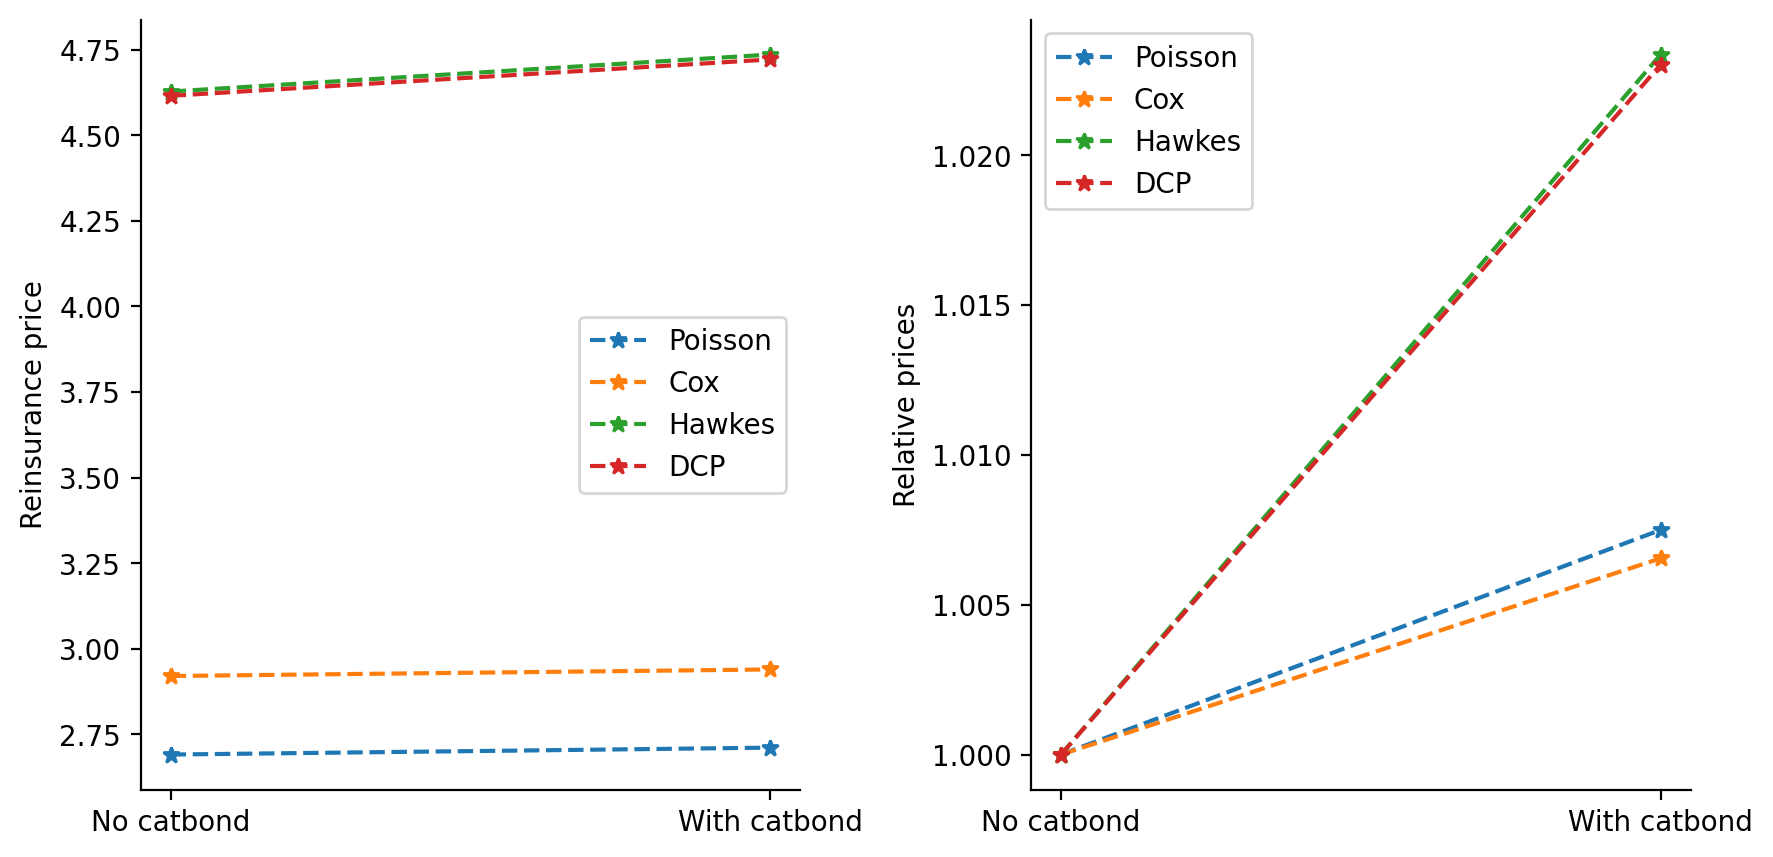

In [ ]:
# Make a subplot with two square plots horizontally
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot on the left subfigure
for i in range(4):
    ax[0].plot(
        [0, 1], [risky_prices[i], safe_prices[i]], label=names[i], ls="--", marker="*"
    )
ax[0].legend()

# Remove top and right splines
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)

# On ax[0], replace x axis ticks with "Without catastrophe bond", "With catastrophe bond" at 0 and 1
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(["No catbond", "With catbond"])

ax[0].set_ylabel("Reinsurance price")

for i in range(4):
    ax[1].plot(
        [0, 1],
        [risky_prices[i] / risky_prices[i], safe_prices[i] / risky_prices[i]],
        label=names[i],
        ls="--",
        marker="*",
    )
ax[1].legend()

# Remove top and right splines
# ax = plt.gca()
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

# On ax[0], replace x axis ticks with "Without catastrophe bond", "With catastrophe bond" at 0 and 1
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(["No catbond", "With catbond"])

ax[1].set_ylabel("Relative prices")

# Add some space between the two subfigures
plt.subplots_adjust(wspace=0.35)

# Increase the font sizes
plt.rcParams.update({"font.size": 14})

plt.savefig("reinsurance_prices_with_and_without_catbonds.png", dpi=300);

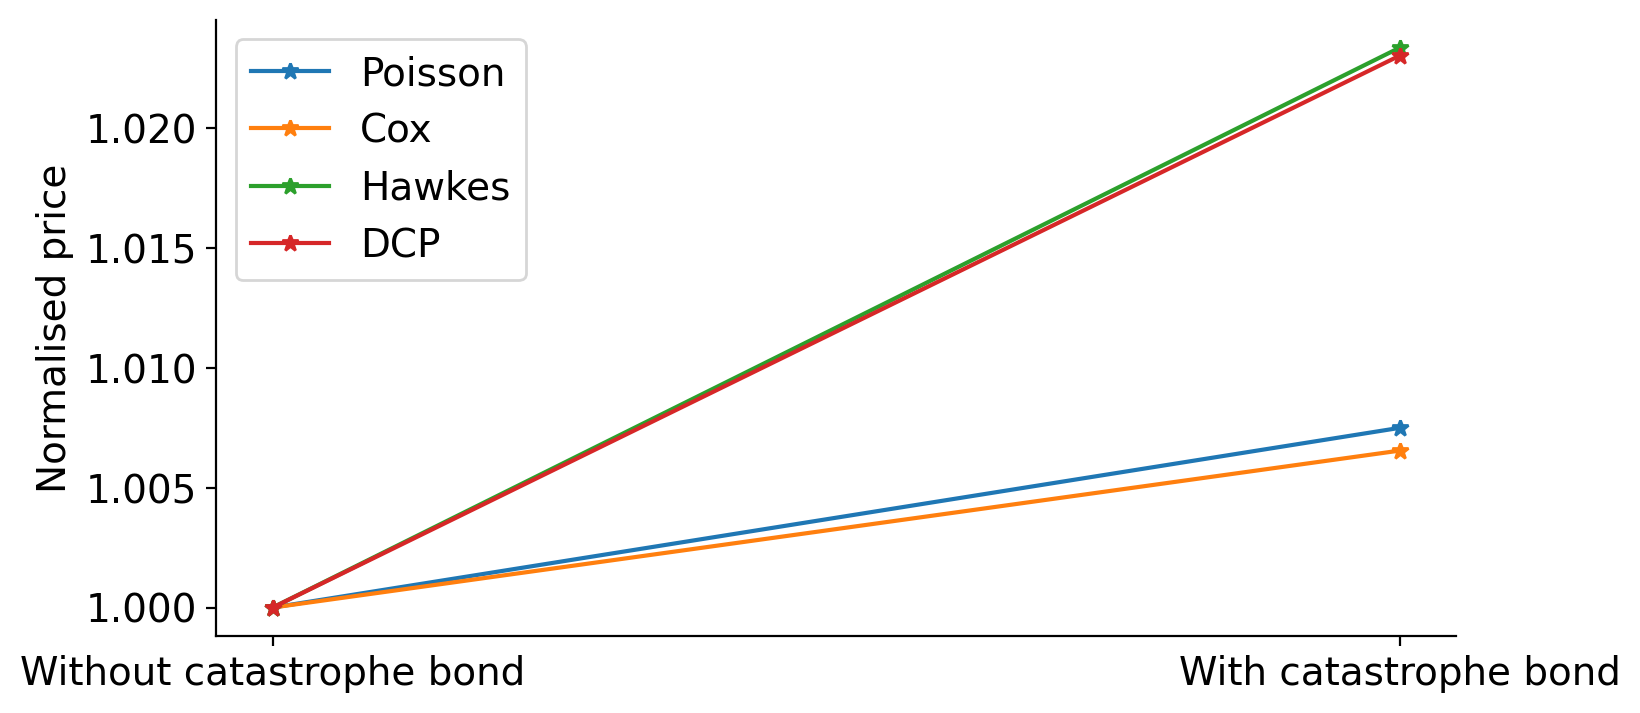

In [ ]:
for i in range(4):
    plt.plot(
        [0, 1],
        [risky_prices[i] / risky_prices[i], safe_prices[i] / risky_prices[i]],
        label=names[i],
        marker="*",
    )
plt.legend()

# Remove top and right splines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Replace x axis ticks with "No catbond" and "Catbond" at 0 and 1
plt.xticks([0, 1], ["Without catastrophe bond", "With catastrophe bond"])

plt.ylabel("Normalised price")
# plt.title("Normalised reinsurance prices with & without catbonds");

plt.gcf().set_size_inches(8, 4)

# Increase font size
plt.rcParams.update({"font.size": 14})

# plt.savefig("reinsurance_prices_with_and_without_catbonds.png", dpi=300);

In [ ]:
delta_0 = catbond_prices(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    upsilon,
    r_0,
    simulate_poisson,
    mu_C,
    sigma_C,
    markup=0.0,
    K=40.0,
    F=10.0,
)

In [ ]:
delta_0

array(0.14153295)

In [ ]:
%%time

Fs = np.linspace(0.0, 2, 5)
present_values = np.empty_like(Fs)

for i, F in enumerate(Fs):
    present_values[i] = reinsurance_prices(
        R,
        seed,
        maturity,
        k,
        eta_r,
        m,
        phi_V,
        sigma_V,
        phi_L,
        sigma_L,
        upsilon,
        V_0,
        L_0,
        r_0,
        simulate_poisson,
        mu_C,
        sigma_C,
        markup=0.0,
        catbond=True,
        K=20.0,
        F=F,
    )

CPU times: total: 1.08 s
Wall time: 1.08 s


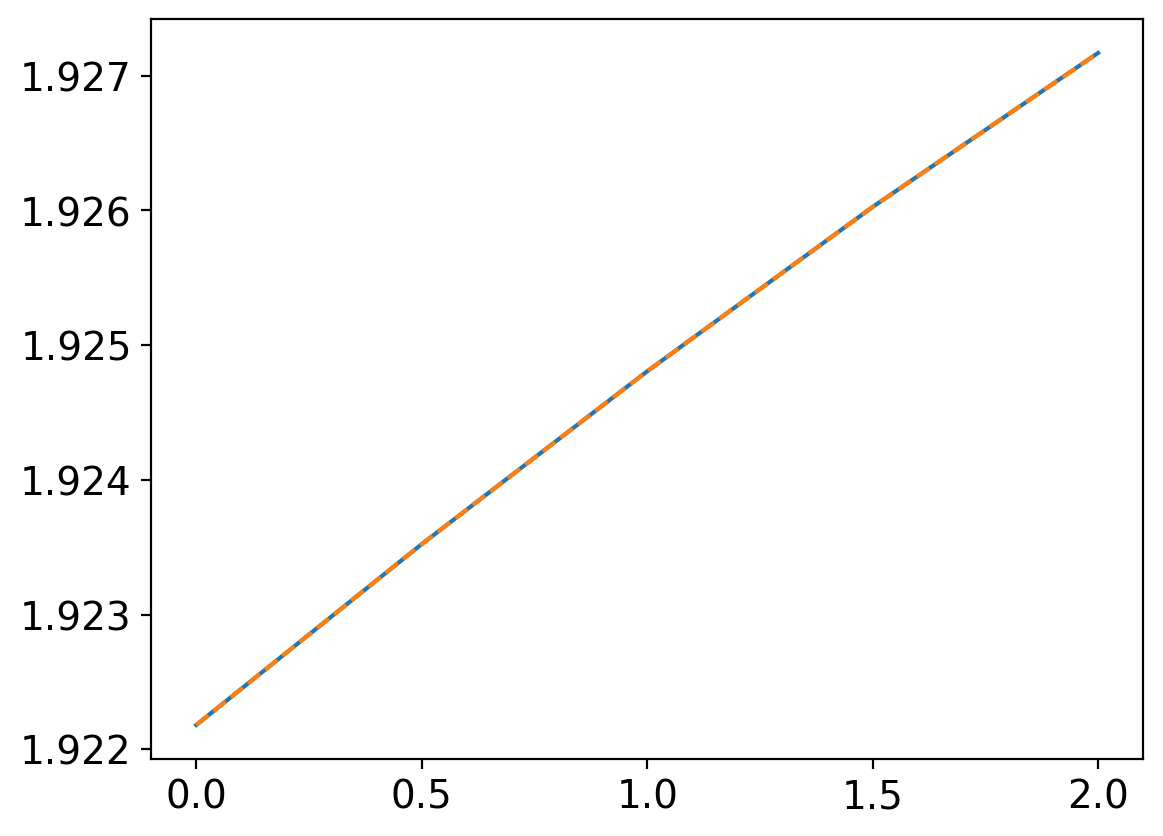

In [ ]:
plt.plot(Fs, present_values)
plt.plot(Fs, present_values, ls="--");

In [ ]:
free_bond = catbond_prices(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    upsilon,
    r_0,
    simulate_poisson,
    mu_C,
    sigma_C,
    markup=0.0,
    K=70.0,
    F=0.0,
)

free_bond

array(0.)

In [ ]:
Fs = np.linspace(0.0, 2, 5)
deltas = np.empty_like(Fs)

for i, F in enumerate(Fs):
    deltas[i] = catbond_prices(
        R,
        seed,
        maturity,
        k,
        eta_r,
        m,
        upsilon,
        r_0,
        simulate_poisson,
        mu_C,
        sigma_C,
        markup=0.0,
        K=10.0,
        F=F,
    )

In [ ]:
deltas

array([0.        , 0.2300133 , 0.45142768, 0.66513143, 0.87064671])

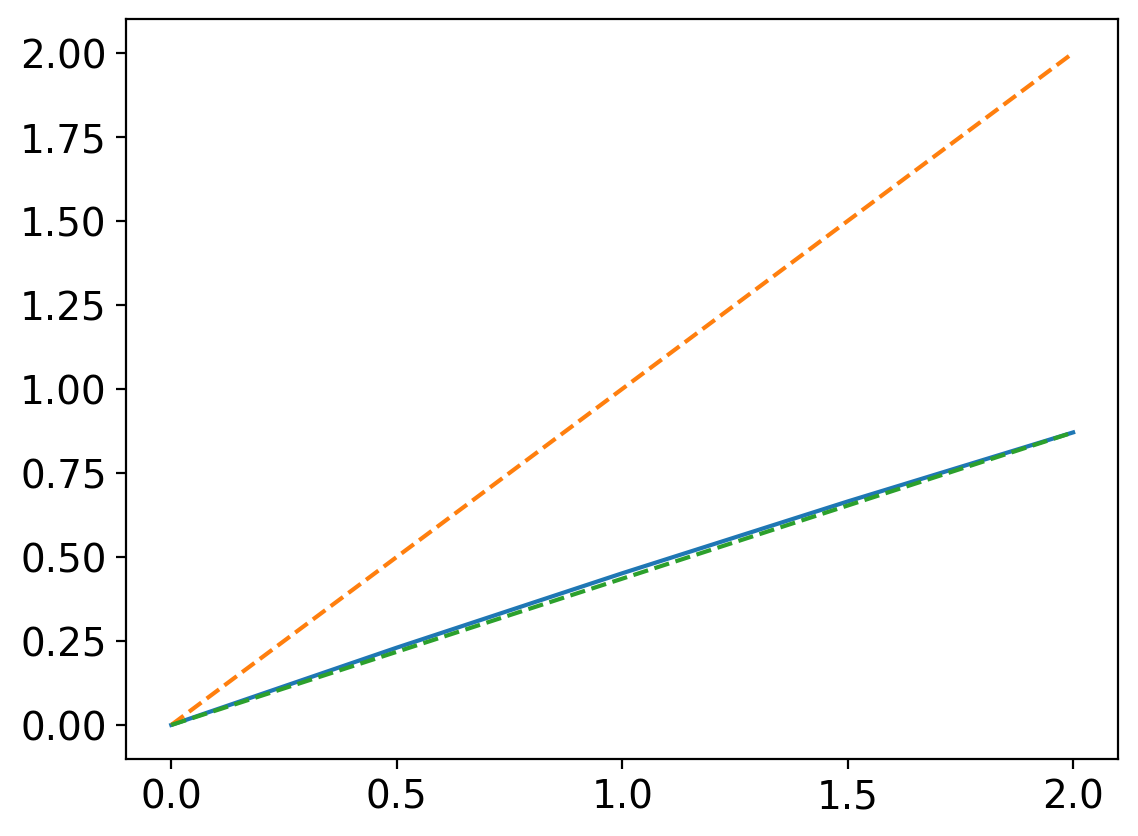

In [ ]:
plt.plot(Fs, deltas)
plt.plot(Fs, Fs, ls="--")
plt.plot(Fs, Fs / Fs[-1] * deltas[-1], ls="--");

## Attempt the optimisation problem (Poisson)

In [ ]:
net_present_value(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    simulate_poisson,
    mu_C,
    sigma_C,
    markup,
    catbond_markup,
    K=20.0,
    F=0.0,
)

array(0.76887239)

In [ ]:
net_present_value(
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    simulate_poisson,
    mu_C,
    sigma_C,
    markup,
    catbond_markup,
    K=20.0,
    F=10.0,
)

array(0.71059466)

In [ ]:
npv = partial(
    net_present_value,
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    simulate_poisson,
    mu_C,
    sigma_C,
    markup,
    catbond_markup,
)

In [ ]:
%%time
A = 20.0
K = A
for F in (0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 100.0, 150.0):
    print(f"K = {K}, F = {F}, NPV = {npv(K, F)}")

K = 20.0, F = 0.0, NPV = 0.7688723938252865
K = 20.0, F = 0.1, NPV = 0.7679497986311213
K = 20.0, F = 0.5, NPV = 0.7643384809374753
K = 20.0, F = 1.0, NPV = 0.7599889879715939
K = 20.0, F = 5.0, NPV = 0.7319793225445038
K = 20.0, F = 10.0, NPV = 0.7105946613737396
K = 20.0, F = 20.0, NPV = 0.6914255115201943
K = 20.0, F = 30.0, NPV = 0.6852979884485868
K = 20.0, F = 40.0, NPV = 0.6834354962436701
K = 20.0, F = 50.0, NPV = 0.6829676337162321
K = 20.0, F = 100.0, NPV = 0.6828450173010011
K = 20.0, F = 150.0, NPV = 0.6828450173009982
CPU times: total: 16.4 s
Wall time: 17.1 s


## Attempt the optimisation problem (DCP)

In [ ]:
npv_dcp = partial(
    net_present_value,
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    simulate_dcp,
    mu_C,
    sigma_C,
    markup,
    catbond_markup,
)

npv_dcp(K=20.0, F=10.0)

array(1.27071631)

In [ ]:
%%time
A = 20.0
K = A
for F in (0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0):
    print(f"K = {K}, F = {F}, NPV = {npv_dcp(K, F)}")

K = 20.0, F = 0.0, NPV = 1.3186336839252848
K = 20.0, F = 0.01, NPV = 1.3185654800068354
K = 20.0, F = 0.05, NPV = 1.318292947320761
K = 20.0, F = 0.1, NPV = 1.3179530544244096
K = 20.0, F = 0.5, NPV = 1.3152847783223438
K = 20.0, F = 1.0, NPV = 1.3120572752996496
K = 20.0, F = 5.0, NPV = 1.2903319304583996
K = 20.0, F = 10.0, NPV = 1.2707163086040512
K = 20.0, F = 20.0, NPV = 1.247808888287324
CPU times: total: 4.97 s
Wall time: 5.08 s


In [ ]:
%%time
no_bond_npv = npv_dcp(K=40.0, F=0.0)

Ks = (20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0)
Fs = (0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0)

npvs = np.empty((len(Ks), len(Fs)), dtype=float)

for i, K in enumerate(tqdm(Ks)):
    for j, F in enumerate(Fs):
        npvs[i, j] = npv_dcp(K, F)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:48<00:00,  6.08s/it]

CPU times: total: 46.9 s
Wall time: 49.2 s


In [ ]:
npvs.round(4)

array([[1.3186, 1.2707, 1.2478, 1.2352, 1.2269, 1.222 , 1.2187, 1.2171,
        1.2163, 1.2159, 1.2157],
       [1.3186, 1.3073, 1.3039, 1.3014, 1.2993, 1.2976, 1.2962, 1.2955,
        1.2951, 1.2949, 1.2948],
       [1.3186, 1.3252, 1.3303, 1.333 , 1.3336, 1.3336, 1.333 , 1.3326,
        1.3324, 1.3323, 1.3322],
       [1.3186, 1.3302, 1.3379, 1.3418, 1.3433, 1.3434, 1.343 , 1.3428,
        1.3427, 1.3426, 1.3426],
       [1.3186, 1.329 , 1.3351, 1.3379, 1.3386, 1.3385, 1.3383, 1.3383,
        1.3382, 1.3382, 1.3382],
       [1.3186, 1.3254, 1.3288, 1.3301, 1.3303, 1.3303, 1.3303, 1.3302,
        1.3302, 1.3302, 1.3302],
       [1.3186, 1.3222, 1.3238, 1.3244, 1.3244, 1.3244, 1.3244, 1.3244,
        1.3244, 1.3244, 1.3244],
       [1.3186, 1.3202, 1.3211, 1.3214, 1.3214, 1.3214, 1.3214, 1.3214,
        1.3214, 1.3214, 1.3214]])

In [ ]:
df = pd.DataFrame(npvs, columns=Fs, index=Ks)
df.index.name = "K"
df

,0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0
K,,,,,,,,,,,
20.0,1.318634,1.270716,1.247809,1.235154,1.226877,1.221997,1.218680,1.217060,1.216294,1.215894,1.215693
30.0,1.318634,1.307300,1.303862,1.301398,1.299258,1.297602,1.296212,1.295474,1.295074,1.294873,1.294806
40.0,1.318634,1.325168,1.330261,1.332954,1.333630,1.333645,1.332956,1.332555,1.332354,1.332288,1.332249
50.0,1.318634,1.330247,1.337852,1.341790,1.343265,1.343354,1.342953,1.342752,1.342686,1.342647,1.342647
60.0,1.318634,1.329001,1.335091,1.337874,1.338632,1.338526,1.338325,1.338258,1.338220,1.338220,1.338220
70.0,1.318634,1.325362,1.328786,1.330137,1.330341,1.330334,1.330267,1.330229,1.330229,1.330229,1.330229
80.0,1.318634,1.322153,1.323766,1.324354,1.324431,1.324422,1.324384,1.324384,1.324384,1.324384,1.324384
90.0,1.318634,1.320247,1.321082,1.321390,1.321393,1.321354,1.321354,1.321354,1.321354,1.321354,1.321354


In [ ]:
df == df.max().max()

,0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0
K,,,,,,,,,,,
20.0,False,False,False,False,False,False,False,False,False,False,False
30.0,False,False,False,False,False,False,False,False,False,False,False
40.0,False,False,False,False,False,False,False,False,False,False,False
50.0,False,False,False,False,False,True,False,False,False,False,False
60.0,False,False,False,False,False,False,False,False,False,False,False
70.0,False,False,False,False,False,False,False,False,False,False,False
80.0,False,False,False,False,False,False,False,False,False,False,False
90.0,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
diff = df - no_bond_npv
diff

,0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0
K,,,,,,,,,,,
20.0,0.0,-0.047917,-0.070825,-0.083480,-0.091757,-0.096637,-0.099954,-0.101573,-0.102340,-0.102740,-0.102941
30.0,0.0,-0.011333,-0.014772,-0.017236,-0.019376,-0.021031,-0.022422,-0.023160,-0.023560,-0.023761,-0.023827
40.0,0.0,0.006534,0.011627,0.014320,0.014996,0.015011,0.014322,0.013921,0.013720,0.013654,0.013615
50.0,0.0,0.011613,0.019218,0.023156,0.024631,0.024720,0.024320,0.024119,0.024052,0.024014,0.024014
60.0,0.0,0.010368,0.016457,0.019241,0.019999,0.019892,0.019691,0.019625,0.019586,0.019586,0.019586
70.0,0.0,0.006728,0.010152,0.011504,0.011708,0.011700,0.011633,0.011595,0.011595,0.011595,0.011595
80.0,0.0,0.003519,0.005132,0.005720,0.005798,0.005789,0.005750,0.005750,0.005750,0.005750,0.005750
90.0,0.0,0.001613,0.002448,0.002756,0.002759,0.002721,0.002721,0.002721,0.002721,0.002721,0.002721


In [ ]:
binary_diff = diff.copy()
binary_diff[binary_diff > 0] = 1
binary_diff[binary_diff < 0] = 0
binary_diff

,0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0
K,,,,,,,,,,,
20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
60.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
70.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
80.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
90.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


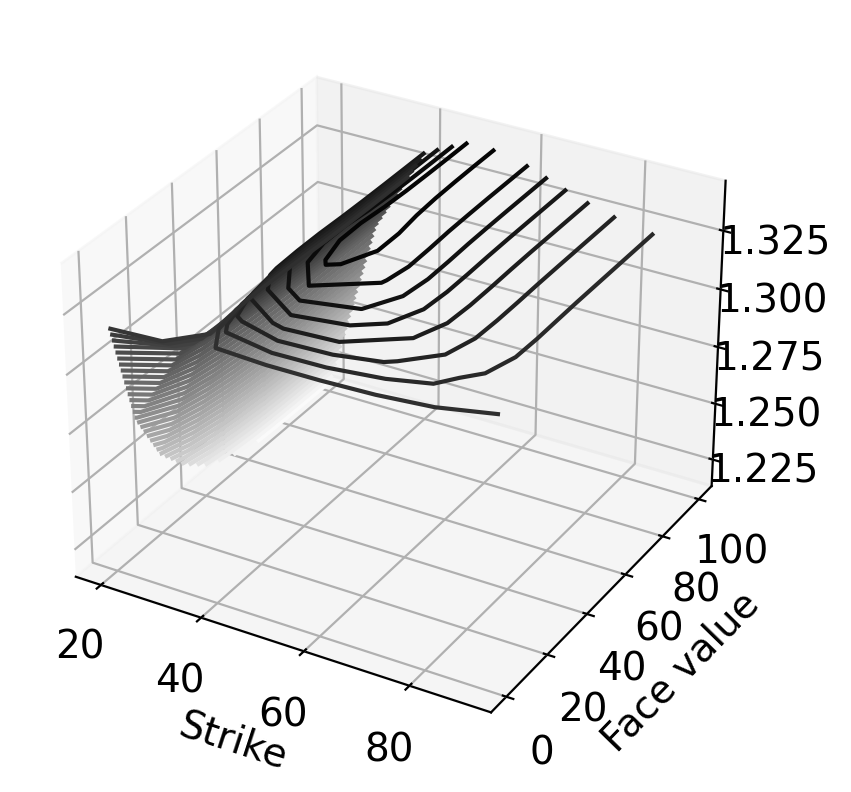

In [ ]:
X = Ks
Y = Fs
X, Y = np.meshgrid(X, Y)
Z = df.to_numpy().T

# Plot the surface.
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.contour3D(X, Y, Z, 50, cmap="binary")

plt.ylabel("Face value")
plt.xlabel("Strike");

In [ ]:
K_reins_opt = 50.0
F_reins_opt = 40.0

## Insurer's point of view

In [ ]:
thc = partial(
    total_hedging_cost,
    R,
    seed,
    maturity,
    k,
    eta_r,
    m,
    phi_V,
    sigma_V,
    phi_L,
    sigma_L,
    upsilon,
    V_0,
    L_0,
    r_0,
    simulate_dcp,
    mu_C,
    sigma_C,
    markup,
    catbond_markup,
    K_reins=K_reins_opt,
    F_reins=F_reins_opt,
)

thc(K_ins=20.0, F_ins=10.0)

1.4496464518905707

In [ ]:
%%time
no_bond_thc = thc(A, 0.0)

Ks = (20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0)
Fs = (0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0)

thcs = np.empty((len(Ks), len(Fs)), dtype=float)

for i, K in enumerate(tqdm(Ks)):
    for j, F in enumerate(Fs):
        thcs[i, j] = thc(K, F)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:48<00:00,  6.10s/it]

CPU times: total: 48.6 s
Wall time: 49.4 s
